<a href="https://colab.research.google.com/github/roy-sub/Time-Series-Air-Quality-Index-Prediction-and-Analysis-using-Multiple-Deep-Learning-Models/blob/main/GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dropout
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD 

In [11]:
# 321300
df = pd.read_csv('/content/air_quality_data_preprocessed')
df.shape

(401611, 33)

In [12]:
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,...,O3_8hr_max,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_calculated,AQI_bucket_calculated
0,16,2013,3,1,15,13.0,16.0,8.0,11.2000,800.0,...,90.0,10.833333,13.000000,7.437500,15.054638,5494.117647,90.0,6,5494.0,Severe
1,17,2013,3,1,16,11.0,22.0,6.0,15.4000,800.0,...,90.0,11.274510,13.529412,7.441176,15.301424,5494.117647,90.0,6,5494.0,Severe
2,18,2013,3,1,17,10.0,20.0,4.0,9.8000,800.0,...,90.0,11.574074,13.888889,7.305556,15.131900,5494.117647,90.0,6,5494.0,Severe
3,19,2013,3,1,18,11.0,20.0,6.0,12.6000,900.0,...,90.0,11.929825,14.210526,7.315789,15.164432,5494.117647,90.0,6,5494.0,Severe
4,20,2013,3,1,19,11.0,31.0,8.0,12.0053,1000.0,...,90.0,12.250000,15.050000,7.450000,15.156541,6082.352941,90.0,6,6082.0,Severe


In [13]:
train = df[:321301]['AQI_calculated']
test = df[321301:401612]['AQI_calculated']

In [14]:
# Normalizing training data # Converted into array as all the methods available are for arrays and not lists
train = np.asarray(train)
train_norm = np.reshape(train, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train_norm)

#Printing
for i in range(5):
    print(train_norm[i])

[0.08080912]
[0.08080912]
[0.08080912]
[0.08080912]
[0.09090597]


In [15]:
train_norm = train_norm[train_norm!=0]

In [16]:
# Normalizing testing data # Converted into array as all the methods available are for arrays and not lists
test = np.asarray(test)
test_norm = np.reshape(test, (-1, 1))

#Scaling all values between 0 and 1 so that large values don't just dominate
scaler = MinMaxScaler(feature_range=(0, 1))
test_norm = scaler.fit_transform(test_norm)

#Printing
for i in range(5):
    print(test_norm[i])

[0.11111683]
[0.12121368]
[0.12121368]
[0.12121368]
[0.12121368]


In [17]:
test_norm = test_norm[test_norm != 0]

In [18]:
print(train_norm.shape)
print(test_norm.shape)

(319942,)
(80251,)


In [19]:
def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return array(x),array(y)

In [20]:
n_steps = 3
X_split_train, y_split_train = split_sequence(train_norm, n_steps)
for i in range(5):
    print(X_split_train[i], y_split_train[i])

[0.08080912 0.08080912 0.08080912] 0.08080912150559791
[0.08080912 0.08080912 0.08080912] 0.09090596881653959
[0.08080912 0.08080912 0.09090597] 0.1010199876365135
[0.08080912 0.09090597 0.10101999] 0.11111683494745518
[0.09090597 0.10101999 0.11111683] 0.11111683494745518


In [21]:
print(X_split_train.shape[0])
print(X_split_train.shape[1])
print(X_split_train.shape)

319939
3
(319939, 3)


In [22]:
print(X_split_train[0])

[0.08080912 0.08080912 0.08080912]


In [23]:
n_features = 1
X_split_train = X_split_train.reshape((X_split_train.shape[0], X_split_train.shape[1], n_features))
for i in range(5):
    print(X_split_train[i])

[[0.08080912]
 [0.08080912]
 [0.08080912]]
[[0.08080912]
 [0.08080912]
 [0.08080912]]
[[0.08080912]
 [0.08080912]
 [0.09090597]]
[[0.08080912]
 [0.09090597]
 [0.10101999]]
[[0.09090597]
 [0.10101999]
 [0.11111683]]


In [24]:
print(X_split_train.shape)

(319939, 3, 1)


In [25]:
X_split_test, y_split_test = split_sequence(test_norm, n_steps)
for i in range(5):
    print(X_split_test[i], y_split_test[i])

[0.11111683 0.12121368 0.12121368] 0.12121368225839686
[0.12121368 0.12121368 0.12121368] 0.12121368225839686
[0.12121368 0.12121368 0.12121368] 0.12121368225839686
[0.12121368 0.12121368 0.12121368] 0.12121368225839686
[0.12121368 0.12121368 0.12121368] 0.12121368225839686


In [26]:
n_features = 1
X_split_test = X_split_test.reshape((X_split_test.shape[0], X_split_test.shape[1], n_features))
for i in range(5):
    print(X_split_test[i])

[[0.11111683]
 [0.12121368]
 [0.12121368]]
[[0.12121368]
 [0.12121368]
 [0.12121368]]
[[0.12121368]
 [0.12121368]
 [0.12121368]]
[[0.12121368]
 [0.12121368]
 [0.12121368]]
[[0.12121368]
 [0.12121368]
 [0.12121368]]


In [27]:
print(X_split_test.shape)

(80248, 3, 1)


In [28]:
# Reshape the input data to have 2 dimensions
X_split_train_2d = X_split_train.reshape(X_split_train.shape[0], -1)
for i in range(5):
    print(X_split_train_2d[i])

[0.08080912 0.08080912 0.08080912]
[0.08080912 0.08080912 0.08080912]
[0.08080912 0.08080912 0.09090597]
[0.08080912 0.09090597 0.10101999]
[0.09090597 0.10101999 0.11111683]


In [29]:
# Reshape the input data to have 2 dimensions
X_split_test_2d = X_split_test.reshape(X_split_test.shape[0], -1)
for i in range(5):
    print(X_split_test_2d[i])

[0.11111683 0.12121368 0.12121368]
[0.12121368 0.12121368 0.12121368]
[0.12121368 0.12121368 0.12121368]
[0.12121368 0.12121368 0.12121368]
[0.12121368 0.12121368 0.12121368]


In [30]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()
rmse = tf.keras.metrics.RootMeanSquaredError()
from sklearn.metrics import r2_score

In [31]:
import tensorflow.keras.backend as K

In [32]:
def rmsle_custom(y_true, y_pred):
    msle = tf.keras.losses.MeanSquaredLogarithmicError()
    return K.sqrt(msle(y_true, y_pred))

#**GRU I**

In [33]:
# design network

regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_split_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_split_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_split_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error', metrics=[msle])
regressorGRU.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 50)             7950      
                                                                 
 dropout (Dropout)           (None, 3, 50)             0         
                                                                 
 gru_1 (GRU)                 (None, 3, 50)             15300     
                                                                 
 dropout_1 (Dropout)         (None, 3, 50)             0         
                                                                 
 gru_2 (GRU)                 (None, 3, 50)             15300     
                                                                 
 dropout_2 (Dropout)         (None, 3, 50)             0         
                                                                 
 gru_3 (GRU)                 (None, 50)                1

In [34]:
# Fitting to the training set
hist = regressorGRU.fit(X_split_train,y_split_train, validation_data=(X_split_test, y_split_test), epochs=50,batch_size=64, verbose = 1)

Epoch 1/50
5000/5000 [==============================] - 52s 8ms/step - loss: 0.0028 - mean_squared_logarithmic_error: 0.0018 - val_loss: 0.0017 - val_mean_squared_logarithmic_error: 0.0011
Epoch 2/50
5000/5000 [==============================] - 40s 8ms/step - loss: 0.0019 - mean_squared_logarithmic_error: 0.0012 - val_loss: 0.0016 - val_mean_squared_logarithmic_error: 0.0011
Epoch 3/50
5000/5000 [==============================] - 40s 8ms/step - loss: 0.0018 - mean_squared_logarithmic_error: 0.0012 - val_loss: 0.0016 - val_mean_squared_logarithmic_error: 0.0010
Epoch 4/50
5000/5000 [==============================] - 39s 8ms/step - loss: 0.0018 - mean_squared_logarithmic_error: 0.0012 - val_loss: 0.0016 - val_mean_squared_logarithmic_error: 0.0010
Epoch 5/50
5000/5000 [==============================] - 40s 8ms/step - loss: 0.0018 - mean_squared_logarithmic_error: 0.0011 - val_loss: 0.0017 - val_mean_squared_logarithmic_error: 0.0011
Epoch 6/50
5000/5000 [==============================] -

#**--------------------------**

In [26]:
yhat = regressorGRU.predict(X_split_test)
for i in range(5):
    print(yhat[i])

2508/2508 [==============================] - 10s 3ms/step
[0.123964]
[0.12229909]
[0.12229909]
[0.12229909]
[0.12229909]


In [27]:
mse = mean_squared_error(y_split_test, yhat)
rmse = sqrt(metrics.mean_squared_error(y_split_test, yhat))
mae= metrics.mean_absolute_error(y_split_test, yhat)
r2= metrics.r2_score(y_split_test, yhat)

print('MSE: %.5f' % mse)
print('RMSE: %.5f' % rmse)
print('MAE: %.5f' % mae)
print('R2: %.5f' % r2)

MSE: 0.00059
RMSE: 0.02424
MAE: 0.01095
R2: 0.95624


In [28]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 25 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')

    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.show()

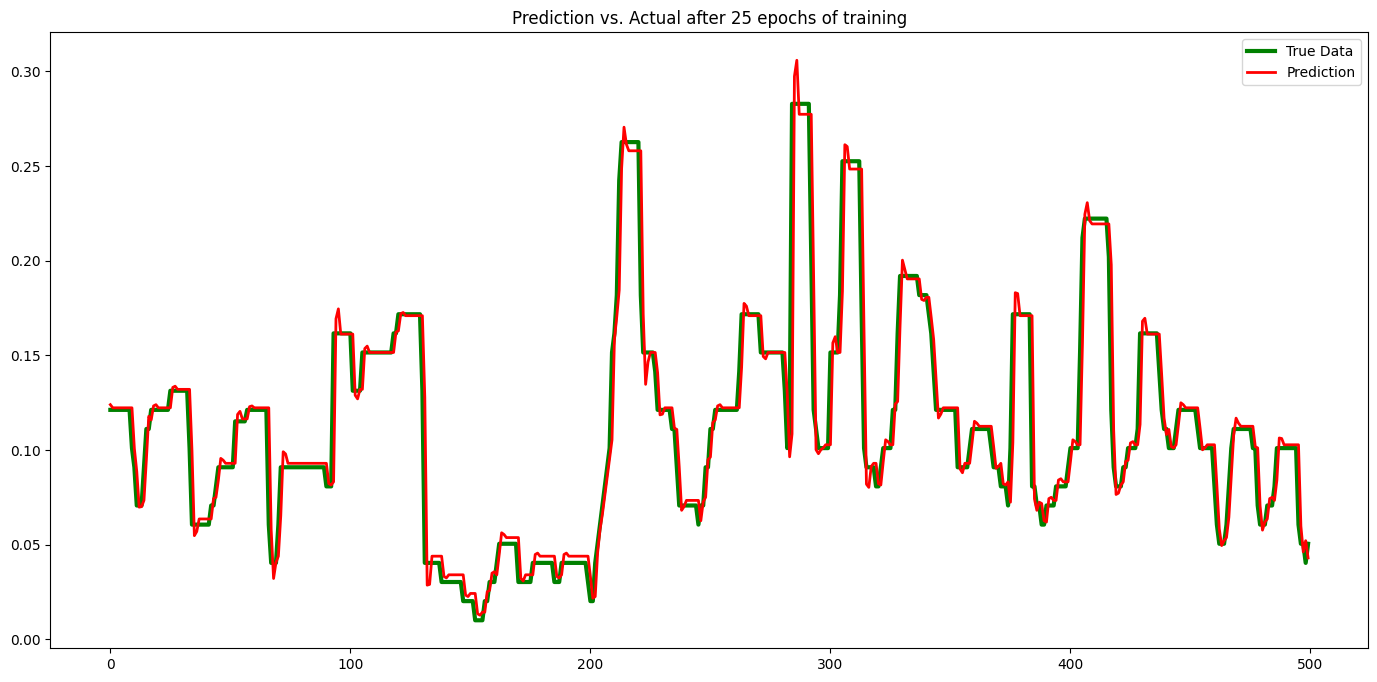

In [29]:
plot_predicted(yhat[:500,], y_split_test[:500,])

In [ ]:
_, train_acc = regressorGRU.evaluate(X_split_train, y_split_train, verbose=0)
_, test_acc = regressorGRU.evaluate(X_split_test, y_split_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.00041, Test: 0.00025


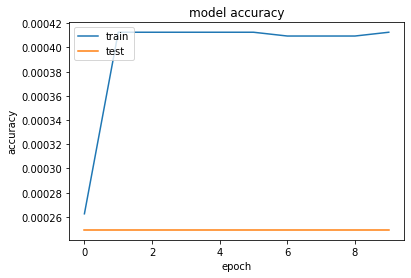

In [ ]:
# Resolve the issue

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

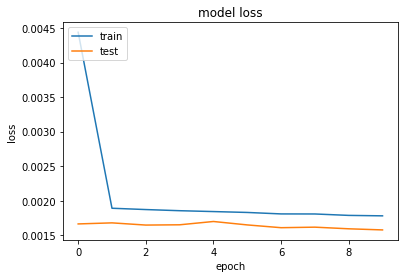

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#**--------------------------**

In [35]:
yhat = regressorGRU.predict(X_split_test)
for i in range(5):
    print(yhat[i])

2508/2508 [==============================] - 8s 3ms/step
[0.12206972]
[0.12027628]
[0.12027628]
[0.12027628]
[0.12027628]


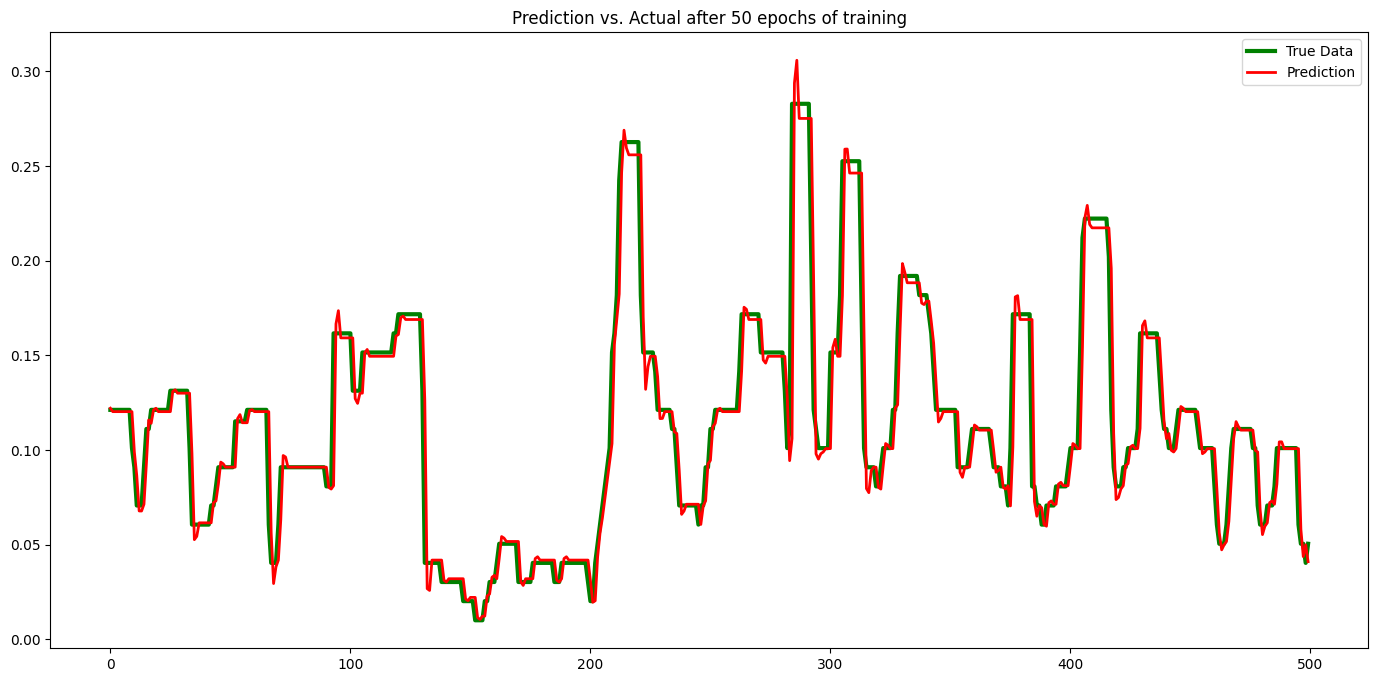

In [36]:
def plot_predicted(predicted_data, true_data):
    fig, ax = plt.subplots(figsize=(17,8))
    ax.set_title('Prediction vs. Actual after 50 epochs of training')
    ax.plot(true_data, label='True Data', color='green', linewidth='3')

    ax.plot(predicted_data, label='Prediction', color='red', linewidth='2')
    plt.legend()
    plt.show()

plot_predicted(yhat[:500,], y_split_test[:500,])

In [37]:
import math
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_split_test[:64252,], yhat[:64252,])
#rmsle = rmsle_custom(y_split_test[:64252,], yhat[:64252,])
#msle = mean_squared_log_error(y_split_test[:64252,], yhat[:64252,])
mae = mean_absolute_error(y_split_test[:64252,], yhat[:64252,])
rmse = math.sqrt(mse)

print('Mean Squared Error: %.5f' % mse)
# print('Root Mean Squared Logarithmic Error: %.5f' % rmsle)
#print('Mean Squared Logarithmic Error: %.5f' % msle)
print('Mean Absolute Error: %.5f' % mae)
print('Root Mean Squared Error: %.5f' % rmse)

Mean Squared Error: 0.00060
Mean Absolute Error: 0.01116
Root Mean Squared Error: 0.02460


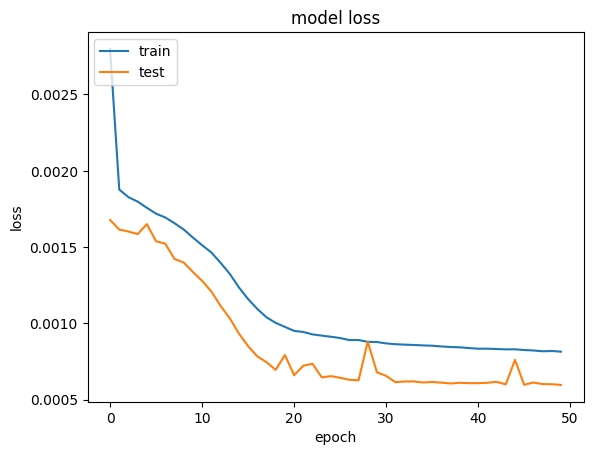

In [38]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

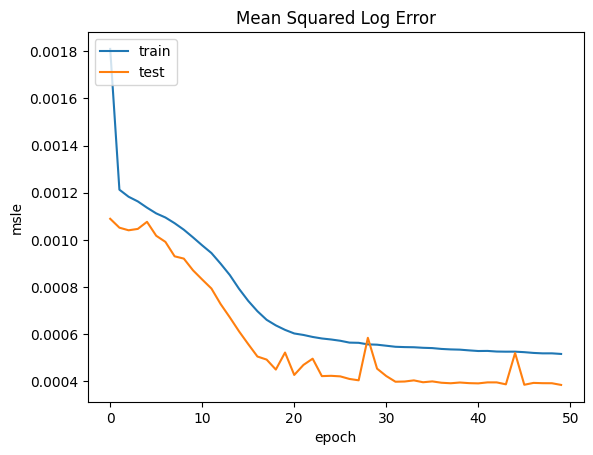

In [41]:
plt.plot(hist.history['mean_squared_logarithmic_error'])
plt.plot(hist.history['val_mean_squared_logarithmic_error'])
plt.title('Mean Squared Log Error')
plt.ylabel('msle')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()